<a href="https://colab.research.google.com/github/framunoz/cv-analyser-with-rag/blob/main/notebooks/colab-rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import typing as t
from IPython.display import Markdown

from google import genai
from google.genai import types

## Configurar tu API key

Para ejecutar los modelos de `genai`, es necesario poseer una API key de Gemini. Por suerte, se puede hacer automáticamente en Google Colab.

Sólo necesitas seleccionar la llave a la izquiera, cliquear en "Gemini API keys", y seleccionar la opción "Import key from Google AI Studio". Te puedes guiar a partir de la imagen:

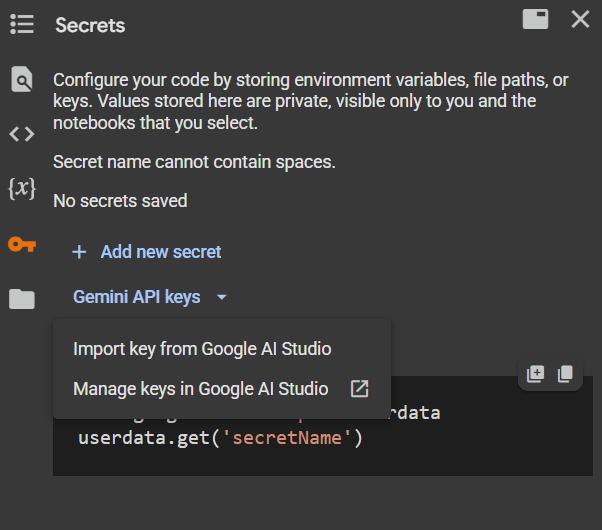

In [2]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")

In [ ]:
cv: dict[str, t.Any] = catalog.load("resume")  # noqa: F821

In [ ]:
client = genai.Client(api_key=GOOGLE_API_KEY)

In [ ]:
def create_documents(resume: dict[str, t.Any]) -> tuple[list[str], list[str]]:
    import yaml

    def fix_accents(text: str) -> str:
        text = text.replace(r"\xE1", "á")
        text = text.replace(r"\xE9", "é")
        text = text.replace(r"\xED", "í")
        text = text.replace(r"\xF3", "ó")
        text = text.replace(r"\xF1", "ñ")

        return text

    documents: list[str] = []
    ids: list[str] = []
    for topic_name, topic in resume.items():
        for item in topic:
            if topic_name in {"certificates", "education", "languages", "volunteer"}:
                continue
            item_parsed = fix_accents(
                yaml.dump(item, default_flow_style=False, width=float("inf"))
            )
            item_parsed = "topic_name: " + topic_name + "\n" + item_parsed
            documents.append(item_parsed)

            id = topic_name + "."
            match topic_name:
                case "certificates":
                    id += item["name"]
                case "education":
                    id += item["studyType"] + "." + item["area"]
                case "languages":
                    id += item["language"]
                case "volunteer":
                    id += item["position"]
                case "work":
                    id += item["name"] + "." + item["position"]
                case _:
                    raise Exception(f"Unknow topic: {topic_name = }, {item = }")
            ids.append(id)

    return documents, ids


documents, ids = create_documents(cv)

In [ ]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry


# Define a helper to retry when per-minute quota is reached.
def is_retriable(e):
    return isinstance(e, genai.errors.APIError) and e.code in {429, 503}


class GeminiEmbeddingFunction(EmbeddingFunction):
    def __init__(self, document_mode: bool = True) -> None:
        self.embedding_task: str = (
            "retrieval_document" if document_mode else "retrieval_query"
        )

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:

        response = client.models.embed_content(
            model="models/text-embedding-004",
            contents=input,
            config=types.EmbedContentConfig(
                task_type=self.embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]

In [ ]:
import chromadb

DB_NAME = "resume"

embed_fn = GeminiEmbeddingFunction(document_mode=True)

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

db.add(documents=documents, ids=ids)

In [ ]:
N_EXP = db.count()

In [ ]:
description = """
En Clay Fintech estamos construyendo productos que integran inteligencia artificial desde el corazón. Creemos que esta tecnología puede transformar tanto nuestros procesos internos como la forma en que ayudamos a nuestros clientes.

Estamos buscando a alguien que se sume a este camino desde etapas tempranas, con muchas ganas de aprender, aportar ideas, y construir junto a nosotros. Si te interesa el mundo de la IA, los datos, y el desarrollo de software, ¡este rol es para ti!


🔧 Lo que harás

Desarrollarás herramientas internas y soluciones para clientes usando tecnologías modernas.
Colaborarás en la creación de agentes de IA, integraciones con APIs, y pipelines de datos.
Probarás nuevas formas de aplicar modelos de lenguaje (LLMs) y otros enfoques de IA.
Participarás activamente en un equipo técnico que valora la autonomía, el aprendizaje continuo y el buen feedback


🌱 Qué buscamos (no necesitas tener todo)

Experiencia programando en Python (proyectos personales, bootcamps, freelance o universidad).
Curiosidad real por la inteligencia artificial y el trabajo con datos.
Conocimientos básicos de bases de datos (SQL o NoSQL).
Buena comunicación, ganas de aprender y trabajar en equipo.
Bonus (no excluyente): experiencia con alguna de estas herramientas o conceptos: Langchain, LlamaIndex, embeddings o retrieval MongoDB PostgreSQL AWS (S3, Lambda, Step Functions)
🎁 Beneficios 🏖️ 5 semanas de vacaciones al año (sí, ¡cinco!)
🕓 Horario flexible y trabajo remoto desde cualquier parte de Chile
🧑‍⚕️ Seguro de salud y dental complementario
📈 Reajuste de sueldo por IPC cada 6 meses
🎂 Día libre en tu cumpleaños (y medio día libre para el de tus hijos)
📚 Tarde libre al mes para recargar energías
📝 3 días administrativos para trámites personales
👥 Ambiente de trabajo buena onda, con foco en el aprendizaje, la colaboración y el crecimiento

📍 Remoto desde Chile (también puedes trabajar desde nuestra oficina si prefieres)

Postula aquí.
"""  # noqa: W293

In [ ]:
# Switch to query mode when generating embeddings.
embed_fn = GeminiEmbeddingFunction(document_mode=False)

# Search the Chroma DB using the specified query.
query = description

result = db.query(query_texts=[query], n_results=min(N_EXP, 7))
[all_passages] = result["documents"]

Markdown(all_passages[0].replace("\n", "  \n"))

In [ ]:
example = """
### Nombre del puesto / Título: Asistente de Investigación
- Nombre de empresa / Negocio: CENIA
- Tipo de industria: Información e Investigación
- Área de trabajo: Educación, Docencia e Investigación
- Subárea de trabajo: Investigación y Desarrollo
- Descripción: "
    [PEQUEÑA DESCRIPCIÓN]
    - [TAREA REALIZADA 1]
    - [TAREA REALIZADA 2]
    - ...
- Palabras clave utilizadas:
"

¿Continuamos? [Y/n]
"""

In [ ]:
query_oneline = query.replace("\n", " ")

prompt = f"""Eres un experto en entrevistas de trabajo, conociendo a detalle el applicant tracking system,
y eres capaz de reconocer las palabras clave a partir de la descripción de una oferta de
trabajo. Necesito que, a partir de la descripción de la oferta de trabajo, y de las
experiencias incluidas más abajo, seas capaz de  modificar las experiencias para que calcen
con las palabras clave de la descripción. De esta manera, que las experiencias sean 100% compatibles
con el applicant tracking system.

Es importante que la descripción sea:
- Compatible con ATS.
- Que tenga un contenido conciso.
- Que resulte convincente para el reclutador.
- Que sea congruente con mi marca personal.
- Que utilice la voz activa: Programé, diseñé, ejecuté...

Solo retorna lo necesario, no agregues palabras de más.

Empieza enlistando las palabras claves detectadas y enlista las 5 experiencias laborales más destacables, en orden
cronológico decreciente con respecto a la fecha de inicio. En una sección aparte, enlista las otras experiencias
que no fueron seleccionadas. SÓLO QUIERO QUE PRESENTES EL TÍTULO DEL PUESTO Y EL NOMBRE DE LA EMPRESA.

EJEMPLO: "
** PALABRAS CLAVES: ** [PALABRA 1], [PALABRA 2], ...
** EXPERIENCIAS LABORALES DESTACADAS: **
- ([FECHA DE INICIO] - [FECHA DE FIN]) [PUESTO 1], [NOMBRE DE LA EMPRESA 1]
- ([FECHA DE INICIO] - [FECHA DE FIN]) [PUESTO 2], [NOMBRE DE LA EMPRESA 2]
- ...
** EXPERIENCIAS LABORALES NO SELECCIONADAS: **
- ([FECHA DE INICIO] - [FECHA DE FIN]) [PUESTO 1], [NOMBRE DE LA EMPRESA 1]
- ([FECHA DE INICIO] - [FECHA DE FIN]) [PUESTO 2], [NOMBRE DE LA EMPRESA 2]
- ...

¿Posees todas las habilidades de las palabras claves? ¿Es necesario modificar alguna experiencia?
"

Como respuesta a tu mensaje, te responderé cuáles son las experiencias que tengo con las palabras claves, y también
si considero que las experiencias laborales están acorde a lo que deseo. Te pediré cambiar alguna experiencia
si se da el caso.

Una vez que haya respondido, presentame la experiencia en el formato que te entrego más abajo.
ES IMPORTANTE QUE MUESTRES SOLO UNA ÚNICA EXPERIENCIA. MENCIONA QUÉ PALABRAS CLAVE UTILIZASTE
PARA MODIFICAR LA OFERTA Y DARLE MAYOR IMPACTO.

Yo decidiré si la descripción es adecuada, donde te pediré modificaciones si es necesario.
Una vez que termine con esa experiencia, procederemos a ver la siguiente experiencia.

EJEMPLO DE FORMATO DE EXPERIENCIA: "{example}"

EXPERIENCIA: "{description}"

"""

# Add the retrieved documents to the prompt.
for passage in all_passages:
    passage_oneline = passage.replace("\n", "  \n")
    prompt += f"EXPERIENCIA: {passage_oneline}\n"

In [ ]:
config = types.GenerateContentConfig(temperature=1, top_p=0.95, top_k=30)
chat = client.chats.create(model="gemini-2.0-flash", history=[], config=config)

response = chat.send_message(prompt)

Markdown(response.text)

In [ ]:
while True:
    print("Para salir, escriba 'q'")  # noqa: T201
    msg: str = input("> ")
    if msg.lower() == "q":
        break
    if not msg:
        msg = "Y"
    print("")  # noqa: T201
    response = chat.send_message(msg)
    print(response.text)  # noqa: T201